In [ ]:
from qubosolver.algorithms.blade.blade import em_blade
from qubosolver.algorithms.blade._helpers import interaction_matrix_from_positions, normalized_distance
from pulser.devices import AnalogDevice
import numpy as np
from pulser import Register
import dataclasses
import matplotlib.pyplot as plt

np.set_printoptions(precision=1, suppress=True)
np.random.seed(0)

device = AnalogDevice

# BLaDE

BLaDE (Balanced Latently Dimensional Embedder) is a method designed at PASQAL that allows to find best positions for atoms for a given problem. We say that we *embed* the problem, and the resulting placement of atoms is called a *register* or *embedding*. When atoms have been prepared in the vacuum chamber of the QPU, they can interact with each other when they are close neighbors. When they are set farther apart, the interaction on each pair of atoms decays rapidly. The formula that defines the amplitude of interaction is $\frac{C_6}{R^6}$, where $C_6$ is a constant that depends on the QPU, and $R$ is the distance between two atoms. Given positions for atoms, we name *interaction matrix* the matrix that contains the amplitude of interaction on each pair of atoms.

When solving a problem on the QPU, in general, we want to target a specific interaction matrix. In particular, when solving a QUBO, we want the interaction matrix to mimic the QUBO matrix, such that each interaction corresponds to a quadratic term of the QUBO.

BLaDE allows to look for the best way to position the atoms, such that the interaction matrix is as close to a target matrix as possible. If the target matrix is a QUBO, it can be used to prepare a register to solve a QUBO. It is an iterative algorithm, that starts from initial positions (e.g. random positions). Then, at each step, it moves points using "forces" to make each interaction get closer to the corresponding quadratic term. In that matter, it takes inspiration from the Fruchterman-Reingold algorithm.

Here, we define a target matrix as the quadratic terms of a QUBO:

In [ ]:
qubo = np.array(
      [[  0.,   3.,  13., 211.,  49.,   5.,  12.,   0.,   0.],
       [  0.,   0.,  23.,   0.,   0.,   4.,   0.,  63.,   2.],
       [  0.,   0.,   0.,   5.,   0.,   1.,   0.,   1.,   0.],
       [  0.,   0.,   0.,   0.,  37.,   0.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   1.,  34.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  35.,   9.,  34.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  70.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

We call `em_blade` to em`BLaDE` the QUBO on the given device:

In [ ]:
positions = em_blade(qubo, device=device)

We compute the interaction matrix for the chosen positions, and observe that the coefficients are close to those of the QUBO:

In [ ]:
interactions = interaction_matrix_from_positions(positions, device=device)
interactions

array([[  0. ,   1.1,  14.2, 211.3,  49.2,   5.5,  12.2,   0.3,   0.2],
       [  0. ,   0. ,  23.2,   0.2,   0.1,   4.3,   0.3,  62.8,   1.8],
       [  0. ,   0. ,   0. ,   3.1,   0.4,   1.3,   0.4,   0.7,   0.2],
       [  0. ,   0. ,   0. ,   0. ,  35.9,   0.4,   1.3,   0.1,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   1.1,  33.3,   0.1,   0.1],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  34.2,   8.4,  34.4],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0.3,   0.8],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  69.8],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ]])

We also compute the distance between the QUBO and the actual interaction matrix, to quickly evaluate how low it is:

In [ ]:
normalized_distance(target=qubo, actual=interactions)

np.float64(0.014640405371090463)

On next sections, we describe how additional parameters can be set to tune the algorithm's behavior.

## Tuning the steps

A feature of BLaDE is that it can go beyond 2 dimensions when evolving the positions. Higher dimensions allow to escape trapped situations, and lower dimensions allow to return to the often desired 2-dimensional space, since we need a register in 2 dimensions. To do so, we can set the parameter `dimensions` as a list of integers, from the starting number of dimensions up to the final one.

On each period of the algorithm, when evolving from a number of dimensions to another one, a specific number of steps is performed. This can also be tuned by setting the parameter `steps_per_round`.

Here is an example where we use fewer dimensions and a smaller number of steps per round than the default values of the function. As a result, it returns very quickly:

In [ ]:
positions = em_blade(qubo, device=device, dimensions=[3,2,2], steps_per_round=50)

We observe however that the coefficients are less accurate:

In [ ]:
interactions = interaction_matrix_from_positions(positions, device=device)
interactions

array([[  0. ,   0.2,   0. , 205.8,  45.9,   5.5,   3.4,   0.4,   0.2],
       [  0. ,   0. ,   0. ,   0.1,   0. ,   0. ,   0. ,  68.1,   1.1],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,  43.3,   0.5,   0.9,   0.1,   0.1],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   2.2,  41.9,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  22.9,   0.2,   0.6],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  73.2],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ]])

It is also reflected by the distance:

In [ ]:
normalized_distance(target=qubo, actual=interactions)

np.float64(0.19477242052393182)

Depending on the target matrices and their sizes, in general, it is for the user to try different values to find the best compromise between speed and quality of result.

It is also possible to input initial positions, to replace the usual random starting positions that the function computes. For example, here, we can use the positions obtained from the previous run to re-optimize them. Since the provided positions are in 2 dimensions, we have to start on 2 dimensions. Then, we can increase the number of dimensions, before returning to 2 dimensions:

In [ ]:
positions = em_blade(qubo, starting_positions=positions, device=device, dimensions=[2,4,4,2], steps_per_round=100)

The new interactions are:

In [ ]:
interactions = interaction_matrix_from_positions(positions, device=device)
interactions

array([[  0. ,   0.6,   0.1, 213.9,  43.4,   8.2,   9.1,   2.8,   0.7],
       [  0. ,   0. ,  28.4,   0.2,   0.1,   0.3,   0.1,  64.6,   1.3],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0.1,   0. ,   3.3,   0.7],
       [  0. ,   0. ,   0. ,   0. ,  37.9,   0.5,   1.2,   0.4,   0.1],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   1.4,  33.4,   0.2,   0.1],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  32.3,   6.8,  35.6],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0.3,   0.5],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  73.4],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ]])

And the new distance is:

In [ ]:
normalized_distance(target=qubo, actual=interactions)

np.float64(0.07469311934721067)

The distance has decreased, although more iterations and/or more dimensions would be required to improve the result further.

## Tuning the objectives

By default, BLaDE applies forces to make each interaction as close as possible to the corresponding coefficient of the target matrix. However, there is sometimes no solution to meet all these objectives simulataneously. In such cases, it can be judicious to give up on some objectives, to better meet other ones. It allows the solution to have a smaller distance from the target overall.

For example, let us take the following target matrix:

In [ ]:
qubo = np.array([
    [0, 1, 0, 0, 1, 1],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0],
])

We embed it using the default parameters:

In [ ]:
positions = em_blade(qubo, device=device)
interactions = interaction_matrix_from_positions(positions, device=device)
interactions

array([[0. , 0.4, 0. , 0. , 0.2, 1.5],
       [0. , 0. , 0.3, 0. , 0. , 0.3],
       [0. , 0. , 0. , 0.3, 0. , 1.5],
       [0. , 0. , 0. , 0. , 0.4, 0.3],
       [0. , 0. , 0. , 0. , 0. , 1.5],
       [0. , 0. , 0. , 0. , 0. , 0. ]])

We observe that each coefficient of the QUBO is taken into account, but very badly. In fact, they are competitve and cannot be satisfied at the same time. The resulting distance is:

In [ ]:
normalized_distance(target=qubo, actual=interactions)

np.float64(0.6569661333473285)

We create a function `compute_max_distance_to_walk` that will decide at each step a maximum move length for points to achieve objectives. In the beginning (starting with `x=0`), it is large enough for points to explore without much constraint, but approaching the last steps (targetting `x=1`), it starts decaying toward 0, forcing points to move more slowly, and satisfy easier objectives in priority:

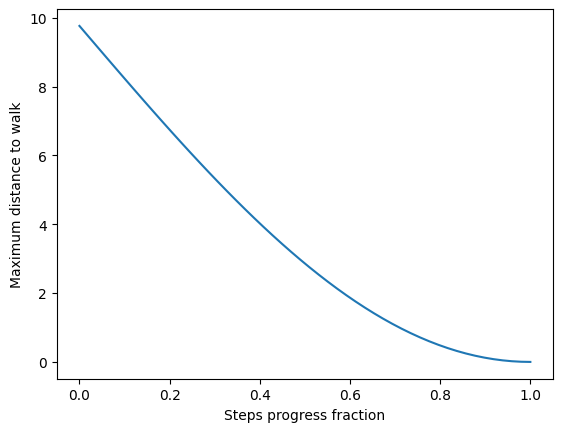

In [ ]:
def compute_max_distance_to_walk(x, _):
    unit_dist = device.rydberg_blockade_radius(1)
    return unit_dist * (1 - np.sin(x * np.pi / 2))

x = np.linspace(0, 1, 50)
y = [compute_max_distance_to_walk(x_val, None) for x_val in x]
plt.plot(x, y)
plt.xlabel('Steps progress fraction')
plt.ylabel('Maximum distance to walk')
plt.show()

The function is assigned to the parameter `compute_max_distance_to_walk`, and we run BLaDE:

In [ ]:
positions = em_blade(qubo, device=device, compute_max_distance_to_walk=compute_max_distance_to_walk)
interactions = interaction_matrix_from_positions(positions, device=device)
interactions

array([[0. , 1. , 0.1, 0. , 0. , 1. ],
       [0. , 0. , 1. , 0. , 0. , 0.1],
       [0. , 0. , 0. , 1. , 0.1, 1. ],
       [0. , 0. , 0. , 0. , 1. , 0.1],
       [0. , 0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. ]])

Now, the interactions are much closer to the target matrix. In fact, they are all close to perfection, except one, that has been abandoned, between points 0 and 4.

The resulting distance reflects that improvement:

In [ ]:
normalized_distance(target=qubo, actual=interactions)

np.float64(0.3591706664391691)

## Meet the device's constraints

Real device have constraints on the coordinates: atoms can not get closer than a given distance, and they must all fit in a disk under a given radius. Since a QUBO matrix can be multiplied by any non zero factor and remains equivalent, distances can also be scaled. Thus, the actual constraint to satisfy is the ratio between the radius and the minimum pairwise distance. The device for this tutorial has the following ratio:

In [ ]:
device.max_radial_distance / device.min_atom_distance

7.6


BLaDE allows to enforce such a constraint, and optimizes the scaling on the minimum pairwise distance and the radius. The flag `enforce_min_max_dist_ratio` must be set to `True` to enable that feature.

We define voluntarily a QUBO that requires a chain of atoms connected to each other, which can necessitate space. Each point is connected to the next two ones:

In [ ]:
size = 25
qubo = np.diag(np.ones(size-1), k=1) + np.diag(np.ones(size-2), k=2)
qubo

array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 

We em`BLaDE` the target matrix using the default method, and draw the result:

/Users/deterrasson/Library/Application Support/hatch/env/virtual/qubo-solver/gLB2xHGn/qubo-solver/lib/python3.10/site-packages/pulser/register/register.py:58: DeprecationWarning: Usage of `int`s or any non-`str`types as `QubitId`s will be deprecated. Define your `QubitId`s as `str`s, prefer setting `prefix='q'` when using classmethods, as that will become the new default once `int` qubit IDs become invalid.
  super().__init__(qubits, **kwargs)


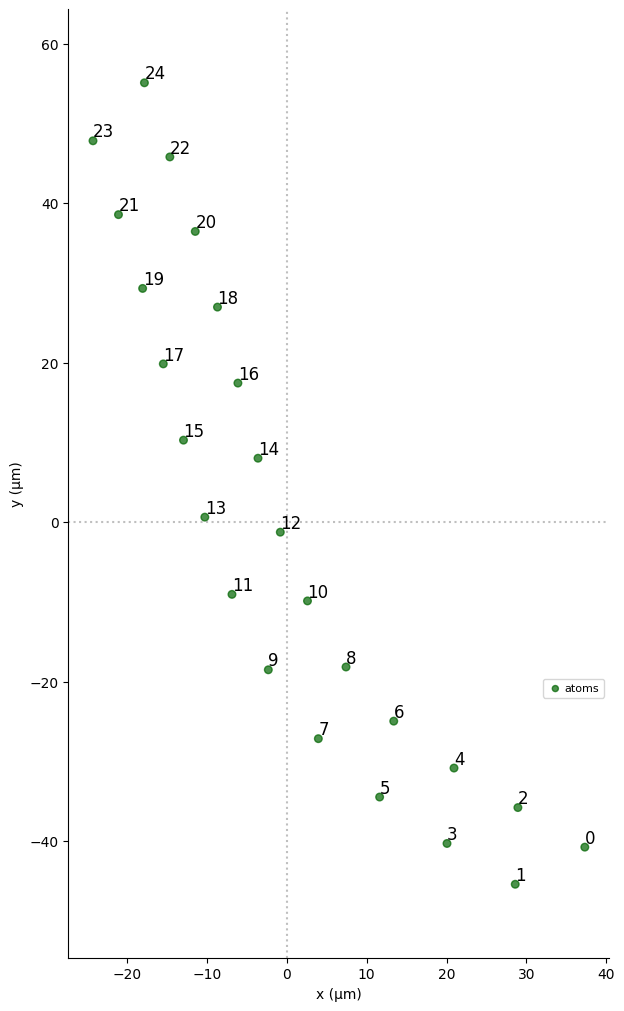

In [ ]:
positions = em_blade(qubo, device=device)
Register.from_coordinates(positions).draw()

We can see that the radius of the circle that contains the atoms is too high compared to the spacing between them. We set the flag `enforce_min_max_dist_ratio` to enforce the ratio constraint:

/Users/deterrasson/Library/Application Support/hatch/env/virtual/qubo-solver/gLB2xHGn/qubo-solver/lib/python3.10/site-packages/pulser/register/register.py:58: DeprecationWarning: Usage of `int`s or any non-`str`types as `QubitId`s will be deprecated. Define your `QubitId`s as `str`s, prefer setting `prefix='q'` when using classmethods, as that will become the new default once `int` qubit IDs become invalid.
  super().__init__(qubits, **kwargs)


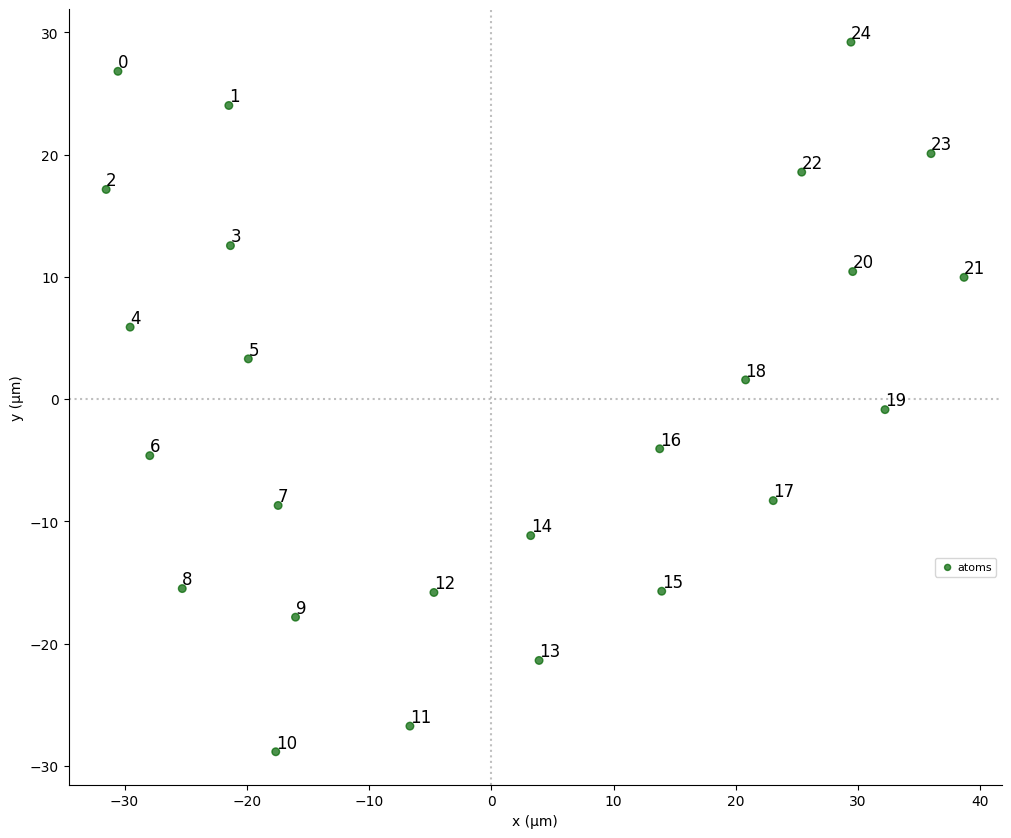

In [ ]:
positions = em_blade(qubo, device=device, enforce_min_max_dist_ratio=True)
interactions = interaction_matrix_from_positions(positions, device=device)
Register.from_coordinates(positions).draw()

Now, the register of atoms is naturally twisted, which allows to meet the ratio constraint.